In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.functional import softplus

#DATA IMPORTING LIBRARIES
# Add the src folder to the path
import sys
sys.path.insert(0, '../src/')

from data.dataloader import MidiDataset
from data.bar_transform import BarTransform
from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split


#half of this is not yet needed but maybe it will be to visualize the latent space
import matplotlib.pyplot as plt
from IPython.display import Image, Audio, display, clear_output
import numpy as np
from sklearn.decomposition import PCA
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

from midi_builder import MidiBuilder
builder = MidiBuilder()


cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NOTESPERBAR=16 #total notes in one bar

totalbars=16 #total bars as input 
NUM_PITCHES=60+1 # all possible notes to play +1 for silences

TOTAL_NOTES=NOTESPERBAR*totalbars

num_features=NUM_PITCHES #size of input feature vector

batch_size = 64 #actual batchsize

TEACHER_FORCING=True #not used but it will be needed


LOADING DATA

In [2]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)#configures number of input bars

midi_dataset = MidiDataset(csv_file='./concat.csv', transform = transform) #imports dataset

midi_dataset.get_mem_usage()

random_seed = 42

test_split = .2
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)
    
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=4)#, sampler=test_sampler)

print("Train size: {}, Test size: {}".format(train_size, test_size))

Train size: 3714, Test size: 928


MODEL:

In [3]:
# define size variables
input_size = NUM_PITCHES

enc_hidden_size=256 #hidden size of encoder
conductor_hidden_size=256 #hidden size of decoder

decoders_hidden_size=64 #hidden size of decoder
decoders_initial_size=32 #decoder input size

n_layers_conductor=2 #not being used rn cuz number of layers is incorrect
n_layers_decoder=3 #not being used rn cuz number of layers is incorrect

latent_features=64 #latent space dimension

sequence_length = 16 #notes per decoder

dropout_rate = 0.2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features,teacher_forcing, eps_i):
        super(VariationalAutoencoder, self).__init__()
        
        self.teacher_forcing = teacher_forcing
        self.eps_i = eps_i

        self.latent_features = latent_features

        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)
        
        #encoded data goes onto connect linear layer. inputs must be*2 because LSTM is bidirectional
        #output must be 2*latentspace because it needs to be split into miu and sigma right after.
        self.encoderOut = nn.Linear(in_features=enc_hidden_size*2, out_features=latent_features*2)
        
        #after being converted data goes through a fully connected layer
        self.linear_z = nn.Linear(in_features=latent_features, out_features=decoders_initial_size)
        
        self.dropout= nn.Dropout(p=dropout_rate)
        
        self.worddropout = nn.Dropout2d(p=dropout_rate)
        
        # Define the conductor and note decoder
        self.conductor = nn.LSTM(decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        self.decoder = nn.LSTM(NUM_PITCHES+decoders_initial_size, decoders_initial_size, num_layers=1,batch_first=True)
        
        # Linear note to note type (classes/pitches)
        self.linear = nn.Linear(decoders_initial_size, NUM_PITCHES)

        
    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)
    
        #2 because has 2 layers
        #n_layers_conductor
        init_conductor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        c_condunctor = torch.zeros(1, batch_size, decoders_initial_size, device=device)
        
        return init,c0,init_conductor,c_condunctor

    # Coin toss to determine whether to use teacher forcing on a note(Scheduled sampling)
    # Will always be True for eps_i = 1.
    def use_teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf
    
    def set_scheduled_sampling(self, eps_i):
        self.eps_i = eps_i

    def forward(self, x):
        batch_size = x.size(0)
        
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)

        the_input = torch.cat([note,x],dim=1)
        
        outputs = {}
        
        #creates hidden layer values
        h0,c0,hconductor,cconductor = self.init_hidden(batch_size)
        
        x = self.worddropout(x)
        
        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))
        
        #x=self.dropout(x)
        
        #goes from 4096 to 1024
        x = self.encoderOut(x)      
        
        #x=self.dropout(x)
        
        # Split encoder outputs into a mean and variance vector 
        mu, log_var = torch.chunk(x, 2, dim=-1)
                
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
               
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        #setting sigma
        sigma = torch.exp(log_var*2)
        
        #generate z - latent space
        z = mu + epsilon * sigma
        
        #decrese space
        z = self.linear_z(z)
        
        #z=self.dropout(z)
        
        #make dimensions fit (NOT SURE IF THIS IS ENTIRELY CORRECT)
        #z = z.permute(1,0,2)

        #DECODER ##############
        
        conductor_hidden = (hconductor,cconductor)
        
        counter=0
        
        notes = torch.zeros(batch_size,TOTAL_NOTES,NUM_PITCHES,device=device)

        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, 1 , NUM_PITCHES,device=device)
        
        # Go through each element in the latent sequence
        for i in range(16):
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size,1, -1), conductor_hidden)    
           
            if self.use_teacher_forcing():
                
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
                
                embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])
                
                e = torch.cat([embedding,the_input[:,range(i*16,i*16+16),:]],dim=-1)
                
                notes2, decoder_hidden = self.decoder(e, decoder_hidden)
                
                aux = self.linear(notes2)
                aux = torch.softmax(aux, dim=2);
                    
                #generates 16 notes per batch at a time
                notes[:,range(i*16,i*16+16),:]=aux;
            else:           
                 # Reset the decoder state of each 16 bar sequence
                decoder_hidden = (torch.randn(1,batch_size, decoders_initial_size,device=device), torch.randn(1,batch_size, decoders_initial_size,device=device))
                
                for _ in range(sequence_length):
                    # Concat embedding with previous note
                    
                    e = torch.cat([embedding, note], dim=-1)
                    e = e.view(batch_size, 1, -1)

                    # Generate a single note (for each batch)
                    note, decoder_hidden = self.decoder(e, decoder_hidden)
                    
                    aux = self.linear(note)
                    aux = torch.softmax(aux, dim=2);
                    
                    notes[:,counter,:]=aux.squeeze();
                    
                    note=aux
                    
                    counter=counter+1


        outputs["x_hat"] = notes
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs

net = VariationalAutoencoder(latent_features, TEACHER_FORCING, eps_i = 1)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): LSTM(61, 256, batch_first=True, bidirectional=True)
  (encoderOut): Linear(in_features=512, out_features=128, bias=True)
  (linear_z): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.2)
  (worddropout): Dropout2d(p=0.2)
  (conductor): LSTM(32, 32, batch_first=True)
  (decoder): LSTM(93, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=61, bias=True)
)


Optimizer

In [4]:
#directly taken from notebook, probably some adaptation might be needed

from torch.nn.functional import binary_cross_entropy
from torch import optim
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence


def ELBO_loss(y, t, mu, log_var, weight):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()

    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)

    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    #kl = -weight * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=(1,2))
    
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - (weight*torch.mean(kl_div)) # add a weight to the kl using warmup
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl_div.mean(),weight*kl_div.mean() # mean instead of sum



# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Testing if forward pass works

In [5]:
from torch.autograd import Variable

#setting dummy data
#Generating dummy data
a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data

a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
data1 = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data1[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data
d=np.zeros((2,TOTAL_NOTES, NUM_PITCHES))
d[0]=data
d[1]=data1

print(d.shape)

#adding 1 dimension, 1x32x4
x = d#data[np.newaxis, :, :]



#setting input ans tensor variable
x = Variable(torch.Tensor(x))

if cuda:
    x = x.cuda()
    
    

#running forward pass
outputs = net(x)


#AFTER THIS NOTHING IS DONE YET ------
x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl,klw = loss_function(x_hat, x, mu, log_var,1)



print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

(2, 256, 61)
torch.Size([2, 256, 61])
torch.Size([2, 256, 61])
torch.Size([2, 256, 32])
tensor(1314.3430, device='cuda:0', grad_fn=<NegBackward>)
tensor(6.1384, device='cuda:0', grad_fn=<MeanBackward1>)


## TRAINING

## Show differences in decay strategies

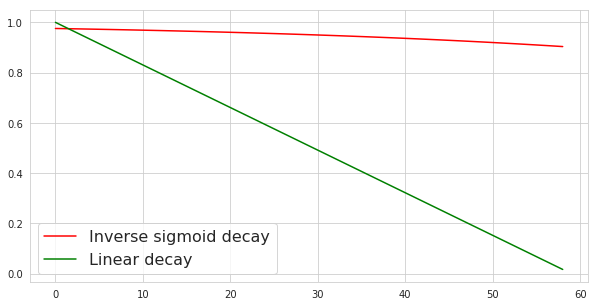

In [6]:
scheduled_decay_rate = 40

def lin_decay(i, mineps=0):
    return np.max([mineps, 1 - (1/len(train_loader))*i])

def inv_sigmoid_decay(i, rate=40):
    return rate/(rate + np.exp(i/rate))

eps = []
for i in range(len(train_loader)):
    eps_i = inv_sigmoid_decay(i, rate=scheduled_decay_rate)
    eps.append(eps_i)

    
eps2 = []
for i in range(len(train_loader)):
    eps_i = lin_decay(i, 0)
    eps2.append(eps_i)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(eps, color="red")
ax.plot(eps2, color="green")
ax.legend(['Inverse sigmoid decay', 'Linear decay'], prop={'size': 16})

## Define warmup for training

Estimated time until completion: 6.67 hours / 400.00 minutes/ 24000.00 seconds


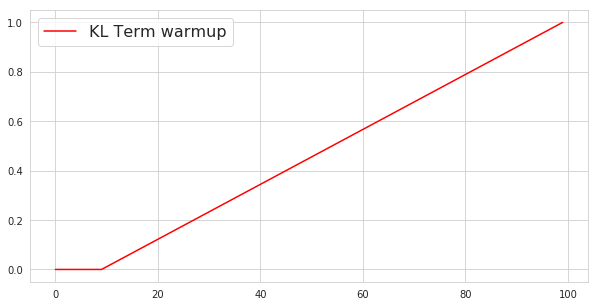

In [8]:
# 3 = ~12 minutes
#num_epochs = 200
#warmup_epochs= 90
#pre_warmup_epochs = 10
num_epochs = 100
warmup_epochs= 90
pre_warmup_epochs = 10

warmup_lerp = 1/warmup_epochs

if warmup_epochs > num_epochs - pre_warmup_epochs:
    warmup_epochs=num_epochs - pre_warmup_epochs


# Plot how the warmup looks
kl_w = 0
kls = []
for e in range(num_epochs):
    if e >= pre_warmup_epochs:
        kl_w = kl_w + warmup_lerp
        if kl_w > 1:
            kl_w=1.

    kls.append(kl_w)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(kls, color="red")
ax.legend(['KL Term warmup'], prop={'size': 16})

est_time = 4*num_epochs
print("Estimated time until completion: {:.2f} hours / {:.2f} minutes/ {:.2f} seconds".format(est_time/60, est_time, est_time*60))

## Train

In [9]:
# from torch.autograd import Variable
import time
import os
import math
tmp_img = "tmp_vae_out.png"

warmup_w=0

eps_i = 1
use_scheduled_sampling = False

train_loss, valid_loss = [], []
train_kl, valid_kl,train_klw = [], [],[]

start = time.time()

print("Training epoch {}".format(0))
#epochs loop
for epoch in range(num_epochs):
    
    batch_loss, batch_kl,batch_klw = [], [],[]
    net.train()

    for i_batch, sample_batched in enumerate(train_loader):
        #if i_batch == 10:
        #    break
        x = sample_batched['piano_rolls']

        x = x.type('torch.FloatTensor')
        
        #if i_batch%10==0:
        #    print("batch:",i_batch)

        x = Variable(x)

        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        ## Calc the sched sampling rate:
        if epoch >= pre_warmup_epochs and use_scheduled_sampling:
            eps_i = inv_sigmoid_decay(i_batch, rate=scheduled_decay_rate)

        net.set_scheduled_sampling(eps_i)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl,kl_w = loss_function(x_hat, x, mu, log_var, warmup_w)

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())
        batch_klw.append(kl_w.item())
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_klw.append(np.mean(batch_klw))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()

        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

        x = x.to(device)

        net.set_scheduled_sampling(1.) # Please use teacher forcing for validations
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl,klw = loss_function(x_hat, x, mu, log_var, warmup_w)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch >= pre_warmup_epochs:
        warmup_w = warmup_w + warmup_lerp
        if warmup_w > 1:
            warmup_w=1.
    
    if epoch == 0:
        continue
            
    # -- Plotting --
    f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
    
    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    
    # KL / reconstruction
    ax = axarr[1]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.plot(np.arange(epoch+1), train_klw, color="blue", linestyle="--")
    ax.legend(['Training', 'Validation','Weighted'])
    
    print("Epoch: {}, {} seconds elapsed".format(epoch, time.time() - start))
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    
    clear_output(wait=True)

    os.remove(tmp_img)

end_time = time.time() - start
print("Finished. Time elapsed: {} seconds".format(end_time))

Finished. Time elapsed: 577.2900624275208 seconds


# Reprint the graph but skip a few epochs

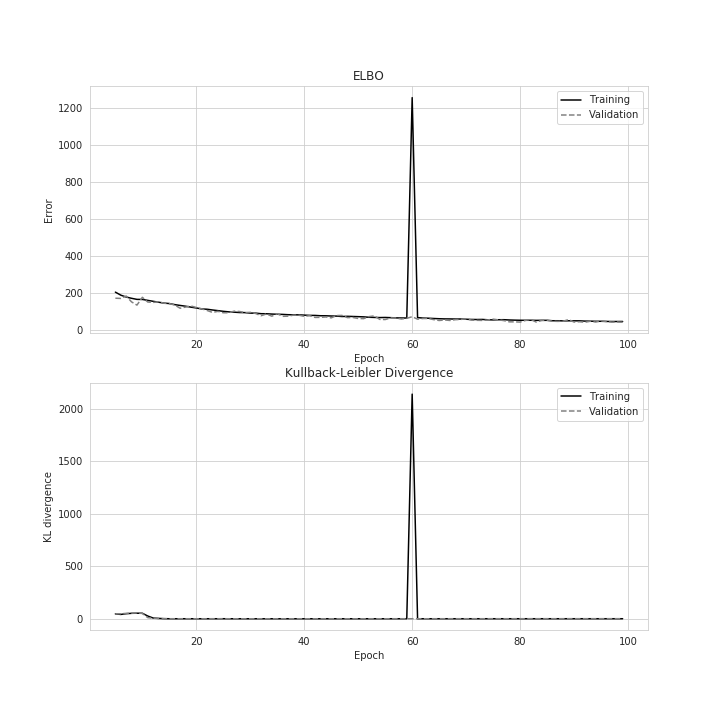

Time elapsed: 577.2900624275208 seconds
-----
Final KL. Train: 0.8200420898906255, Validation: 0.7684836387634277
Final loss. Train: 45.32209228257001, Validation: 41.439788818359375


In [10]:
skip = 5
save_img = os.path.join("midi","kl_elbo.png")
if skip > num_epochs:
    print("Can't skip more than epochs run.")
    skip = 0

f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
# Loss
ax = axarr[0]
ax.set_title("ELBO")
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')

ax.plot(np.arange(skip, epoch+1), train_loss[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_loss[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])

# KL / reconstruction
ax = axarr[1]

ax.set_title("Kullback-Leibler Divergence")
ax.set_xlabel('Epoch')
ax.set_ylabel('KL divergence')


ax.plot(np.arange(skip, epoch+1), train_kl[skip:], color="black")
ax.plot(np.arange(skip, epoch+1), valid_kl[skip:], color="gray", linestyle="--")
ax.legend(['Training', 'Validation'])

plt.savefig(save_img)
plt.close(f)
display(Image(filename=save_img))

print("Time elapsed: {} seconds".format(end_time))

print("-----")

print("Final KL. Train: {}, Validation: {}".format(train_kl[-1], valid_kl[-1]))
print("Final loss. Train: {}, Validation: {}".format(train_loss[-1], valid_loss[-1]))

# Show reconstructions

/home/marius/Documents/Cours/M1/apprentissage/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


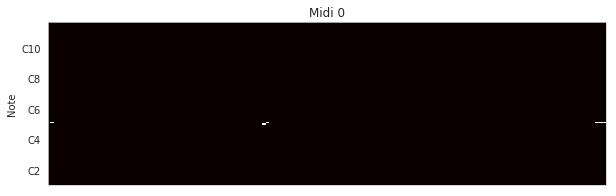

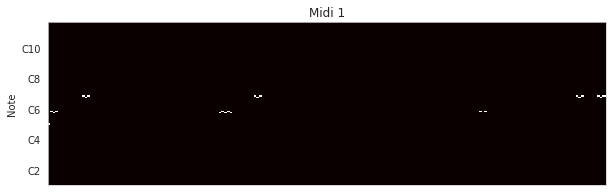

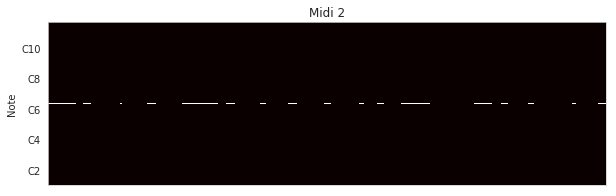

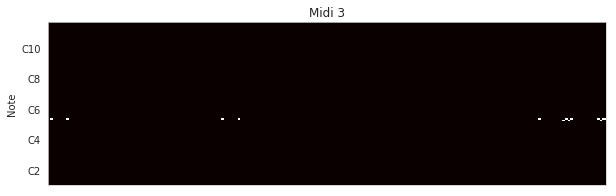

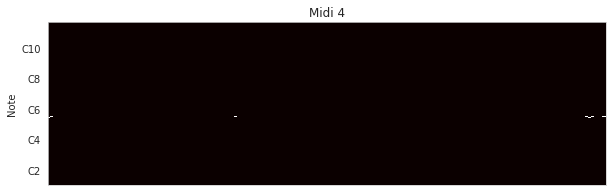

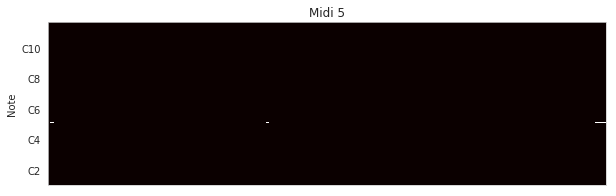

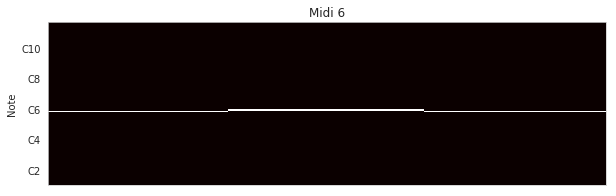

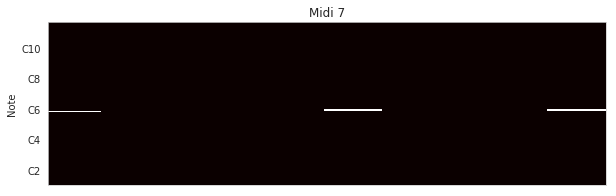

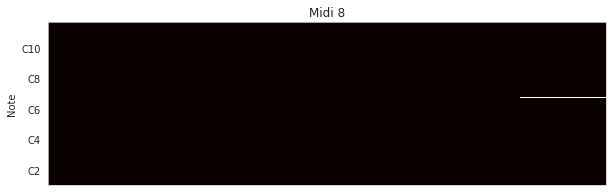

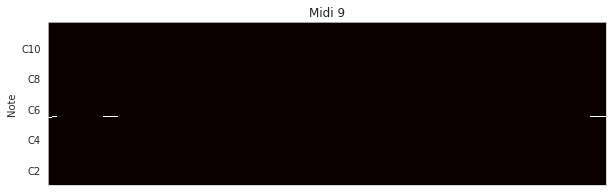

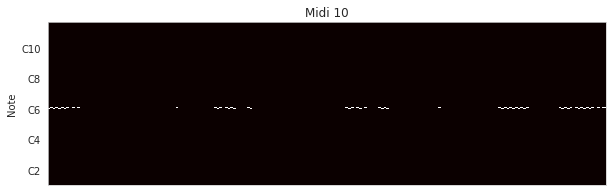

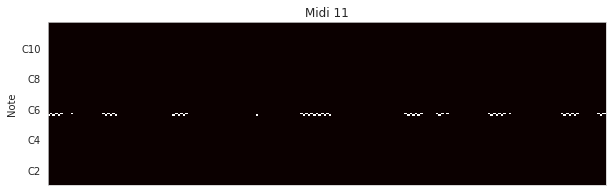

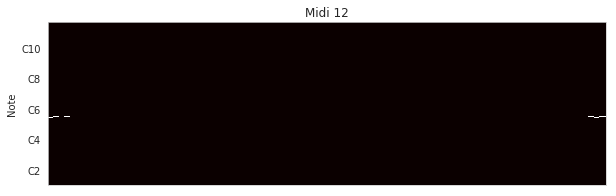

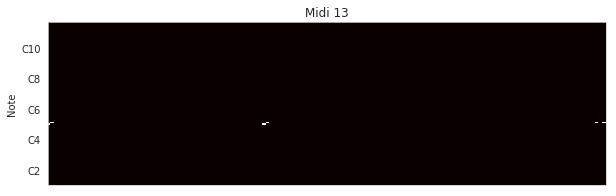

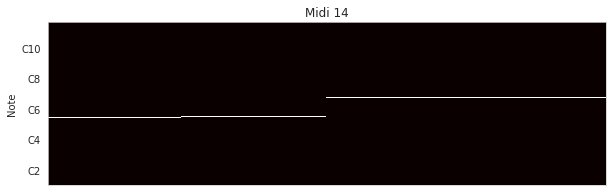

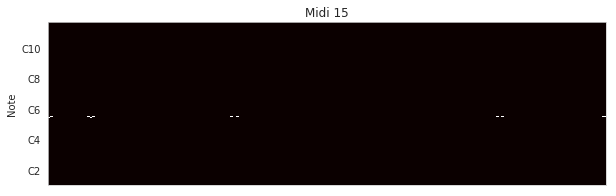

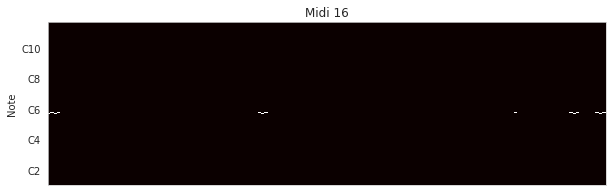

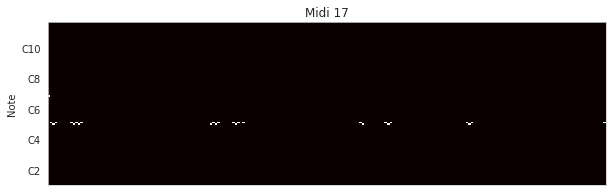

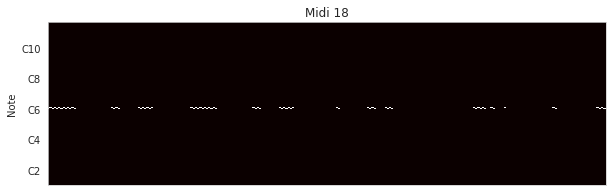

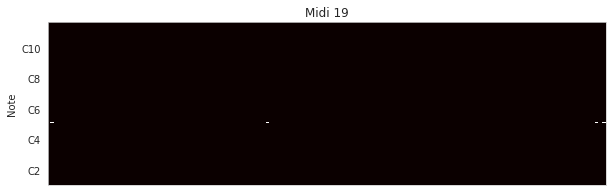

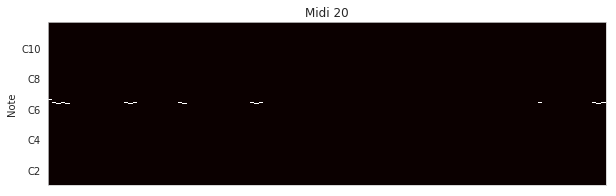

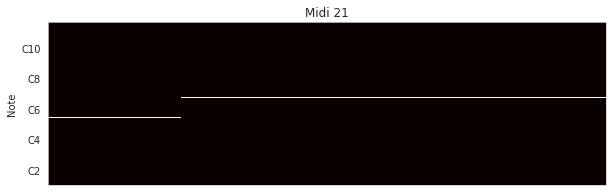

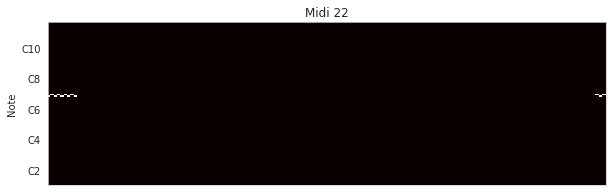

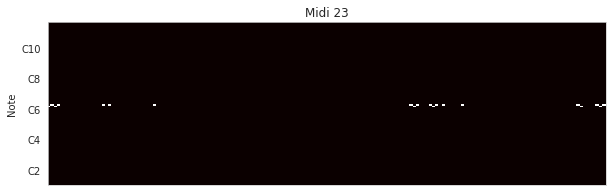

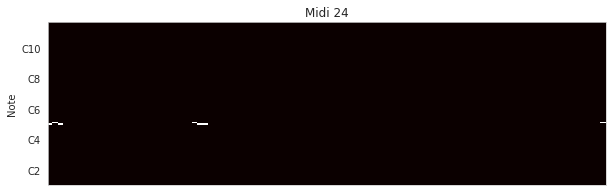

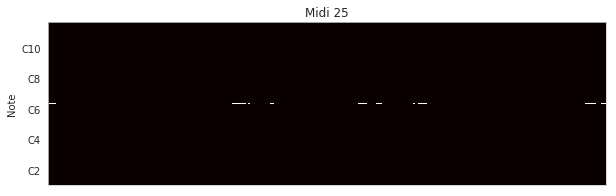

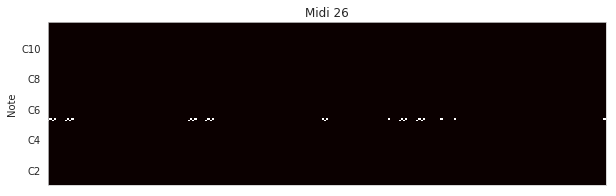

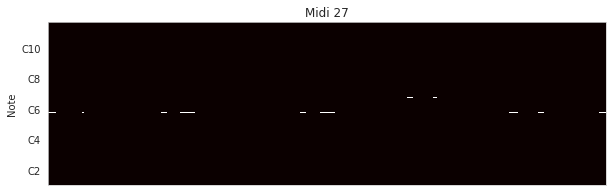

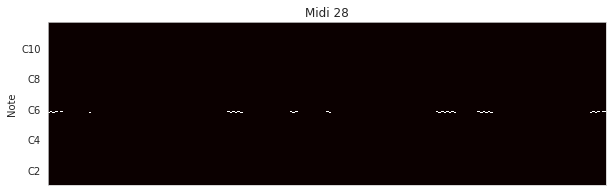

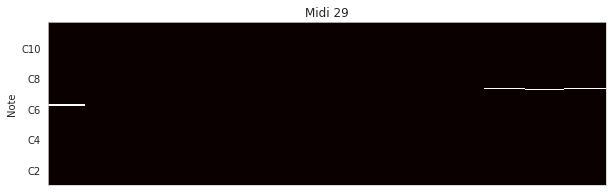

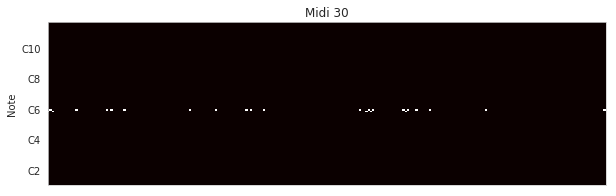

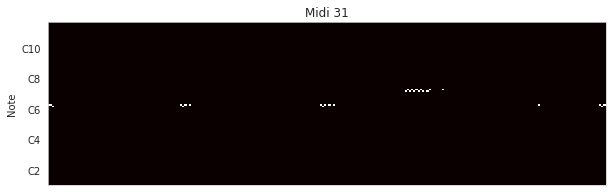

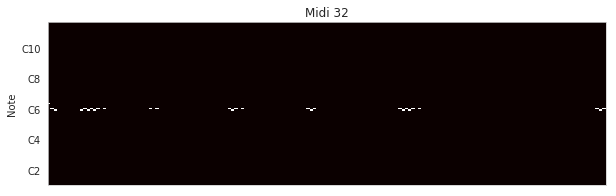

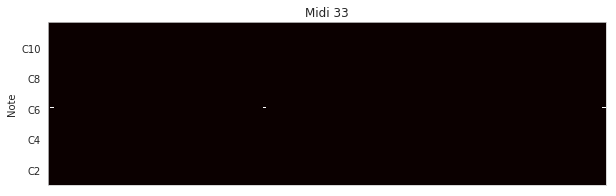

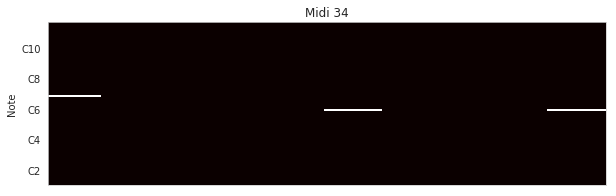

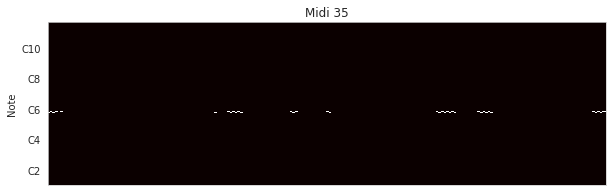

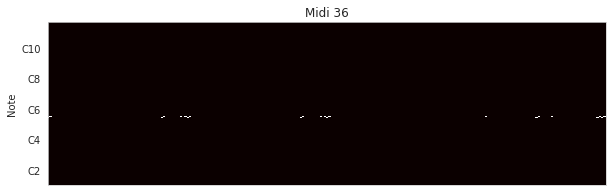

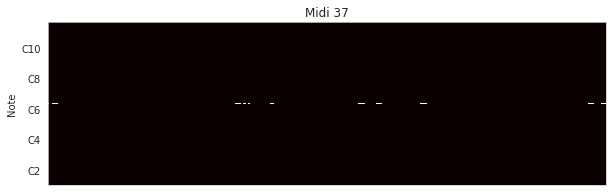

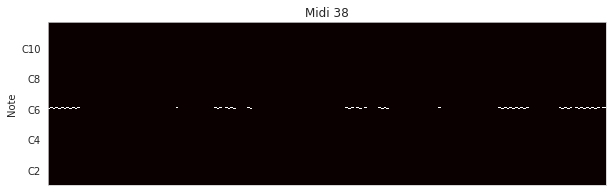

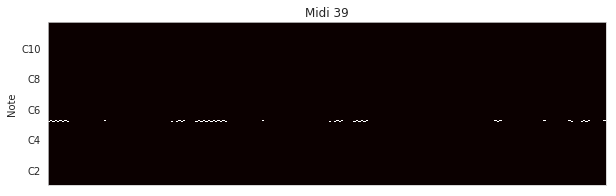

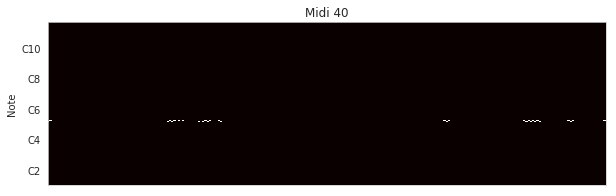

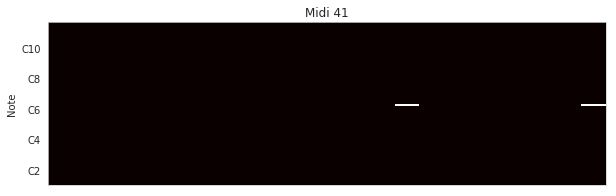

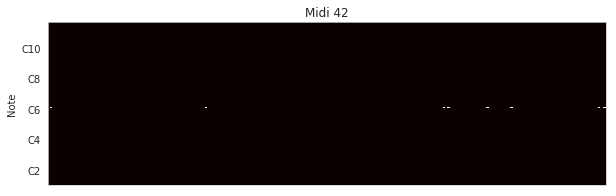

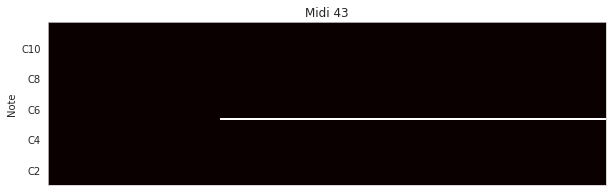

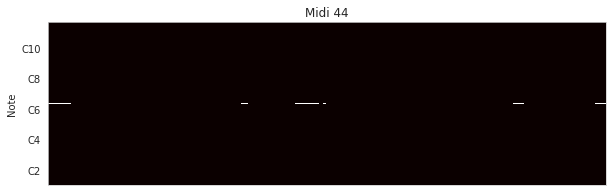

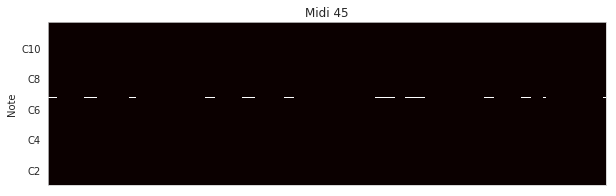

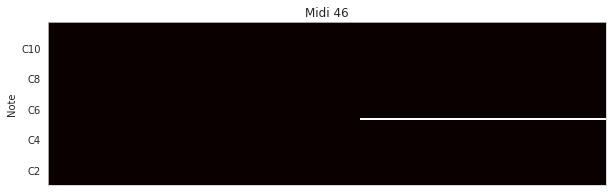

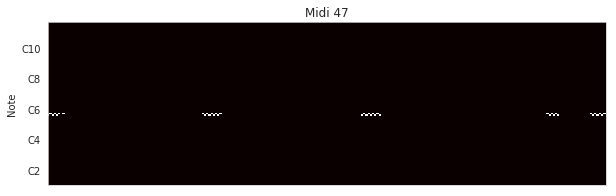

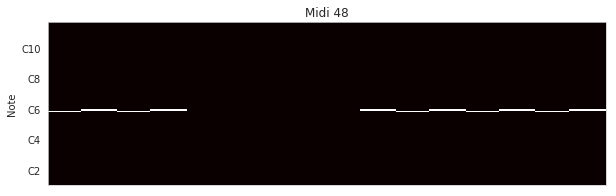

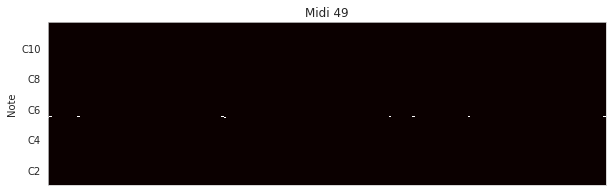

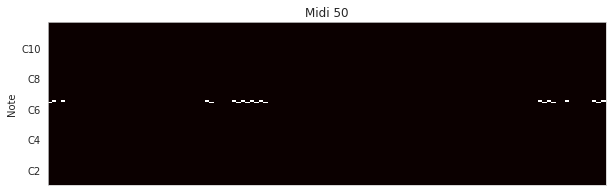

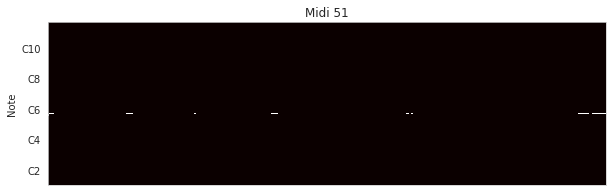

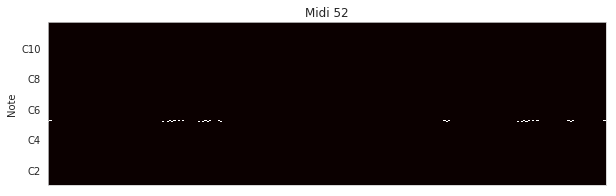

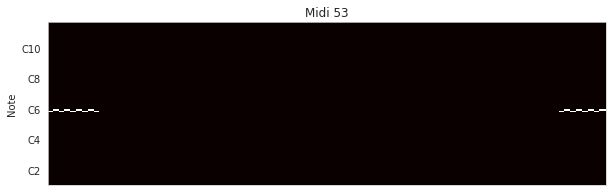

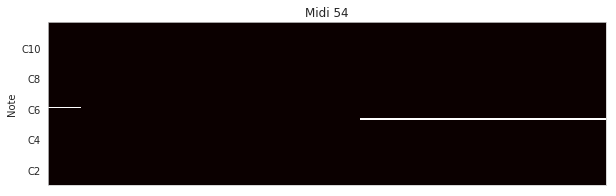

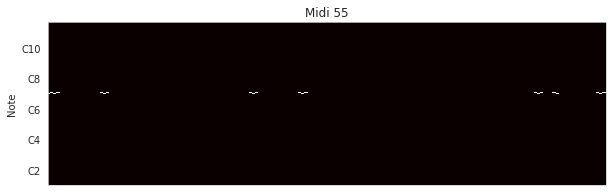

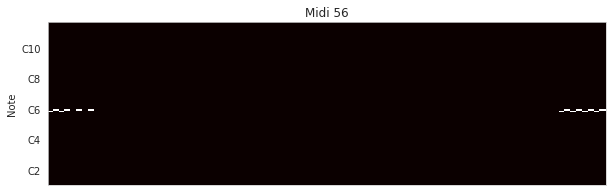

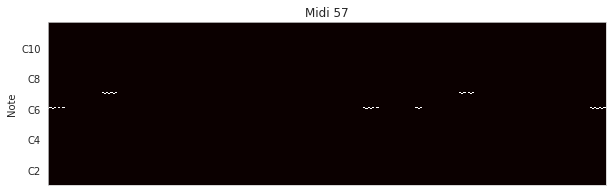

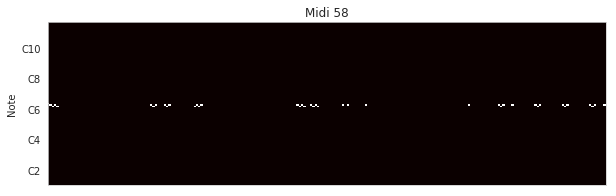

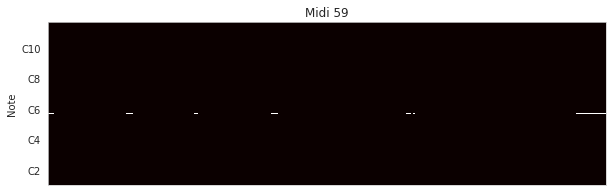

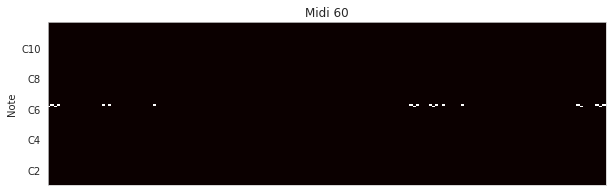

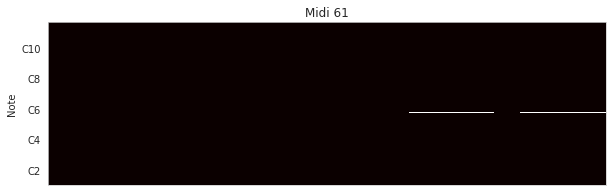

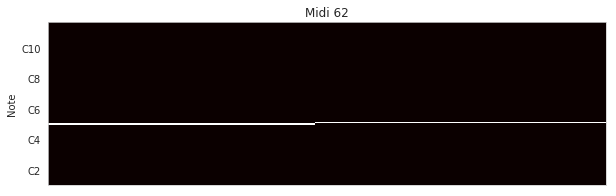

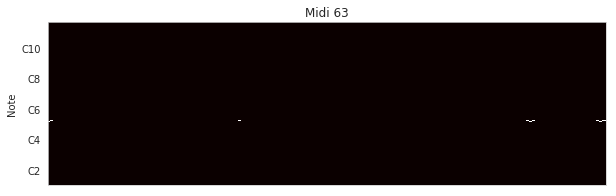

In [11]:
if not os.path.exists('midi'):
    os.makedirs('midi')

x_hat_np = x_hat.detach().numpy()
x_hat_np.shape
for i, seq in enumerate(x_hat_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue

    np.savetxt("midi/csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Midi {}".format(i))
    
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}.png".format(i))

    midi.write('midi/{}.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

# Compare to originals

/home/marius/Documents/Cours/M1/apprentissage/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


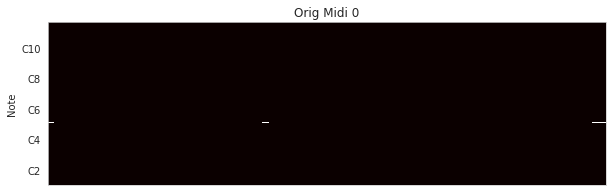

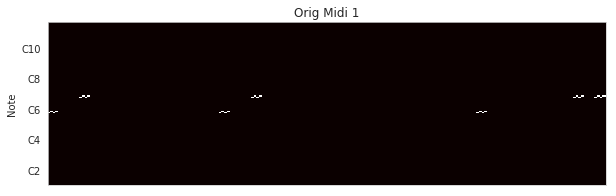

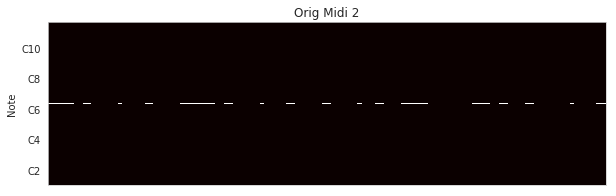

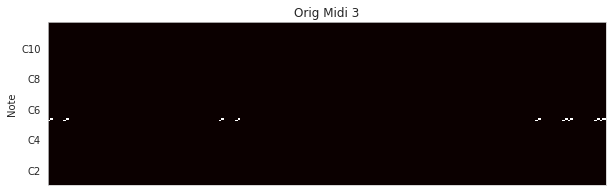

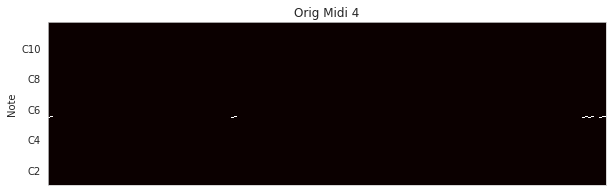

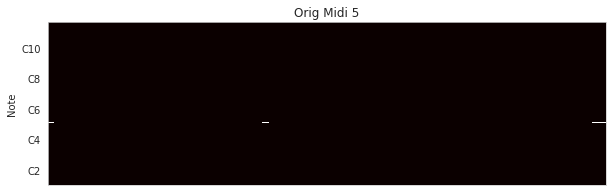

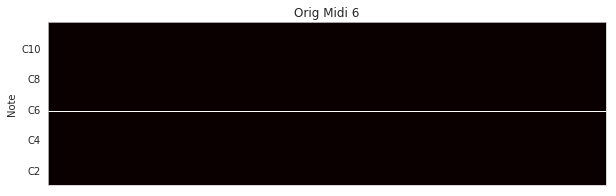

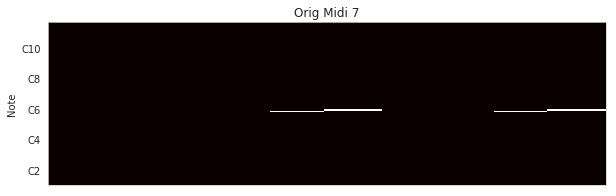

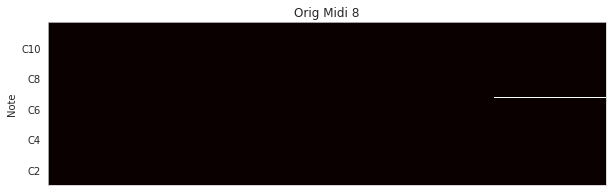

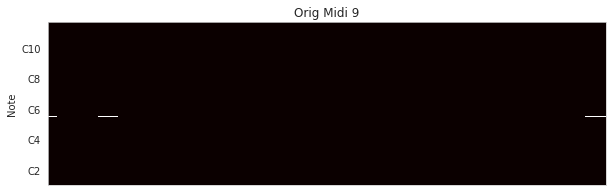

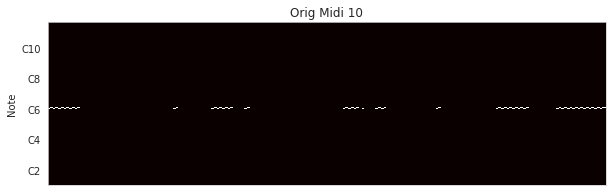

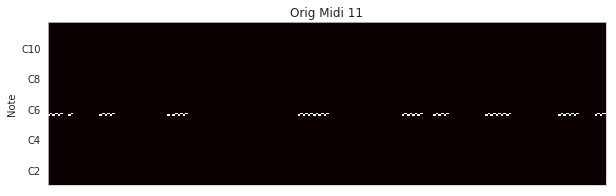

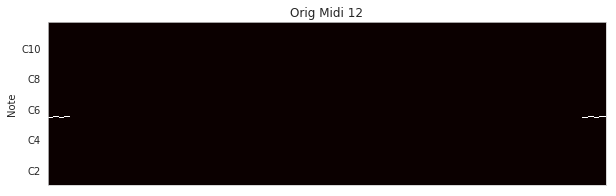

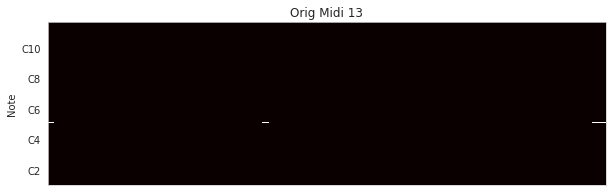

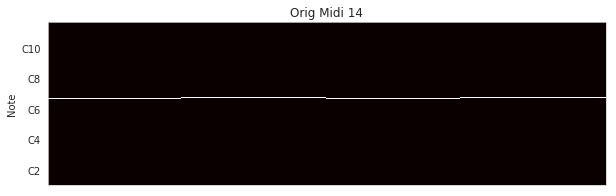

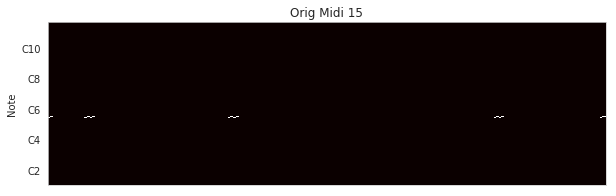

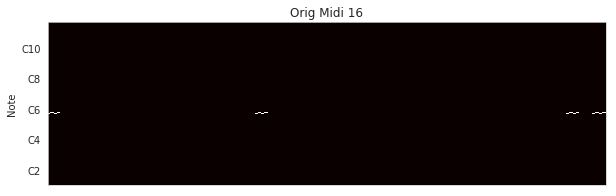

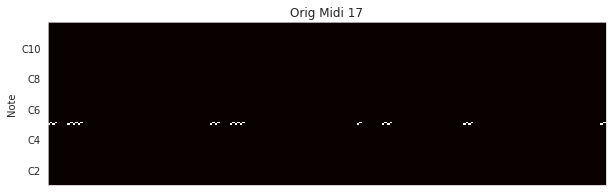

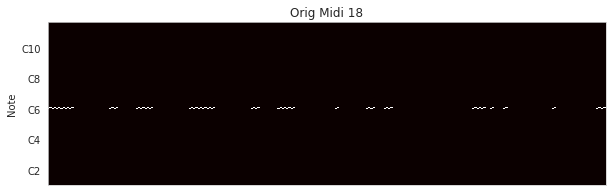

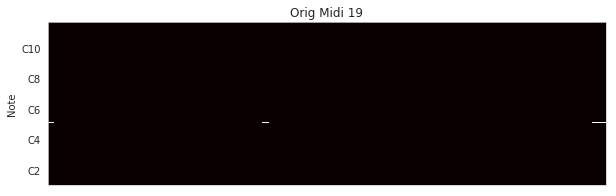

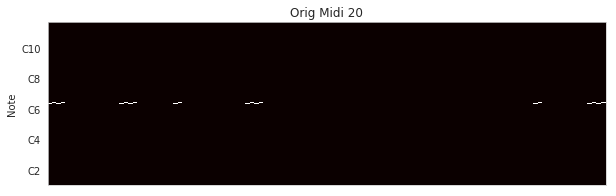

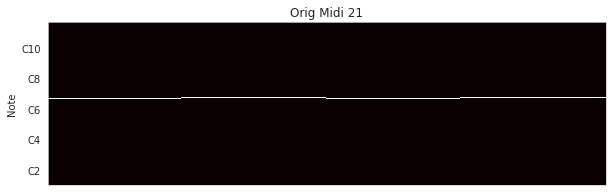

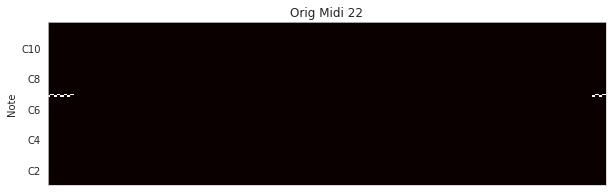

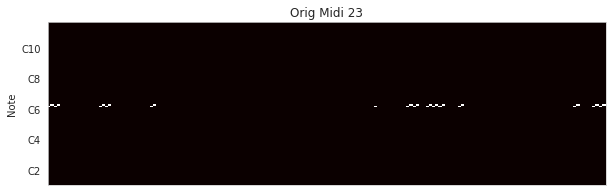

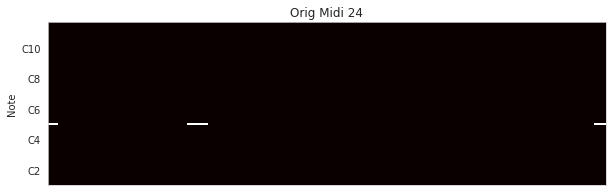

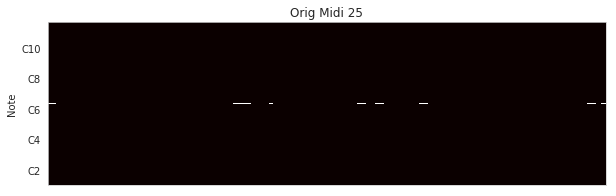

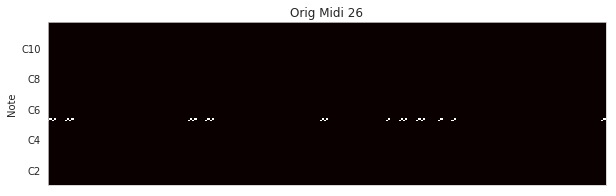

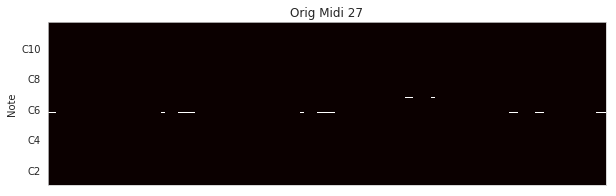

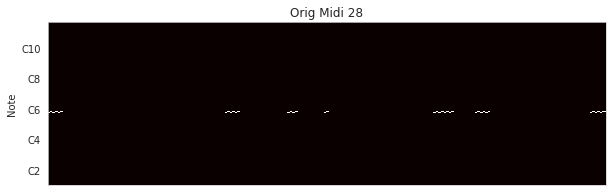

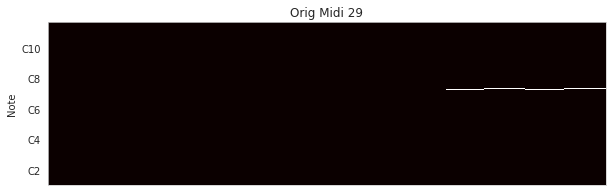

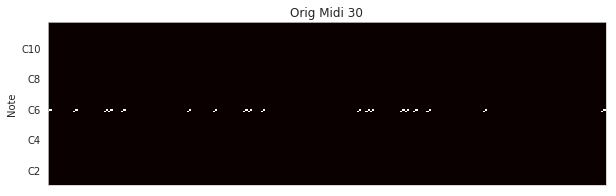

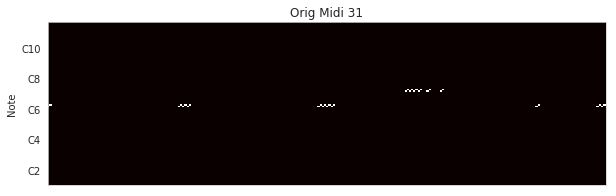

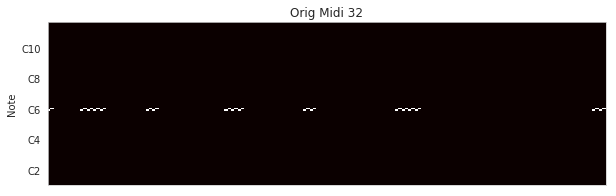

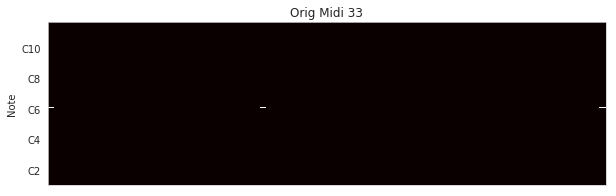

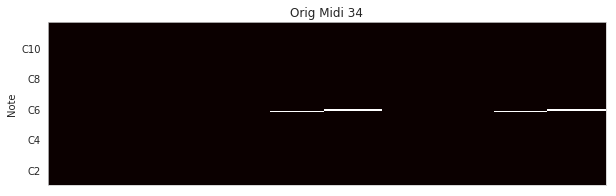

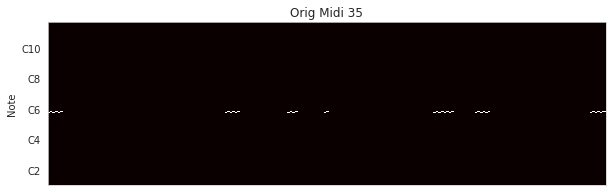

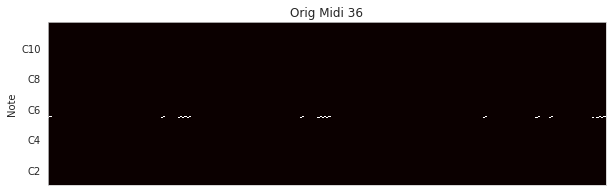

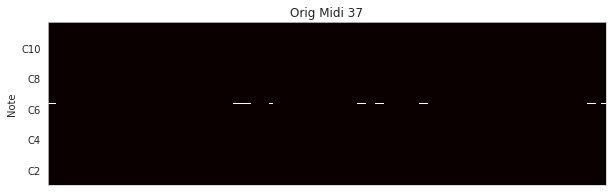

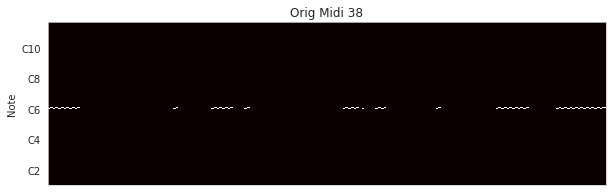

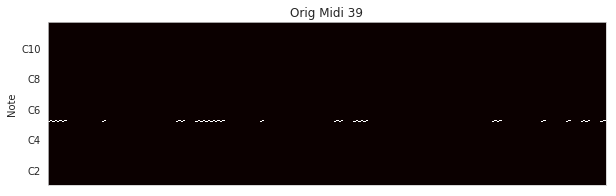

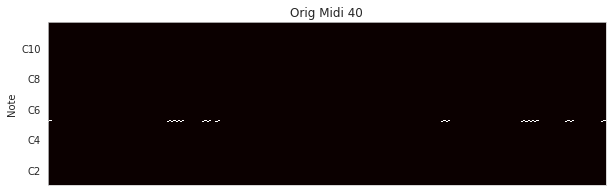

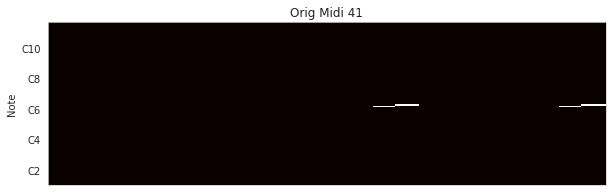

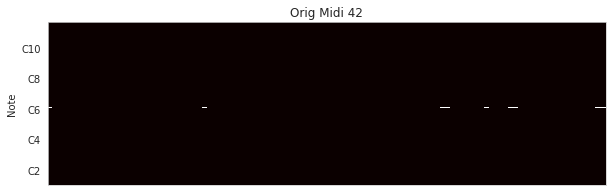

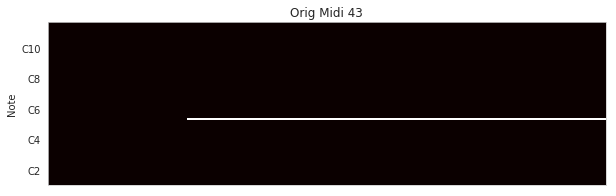

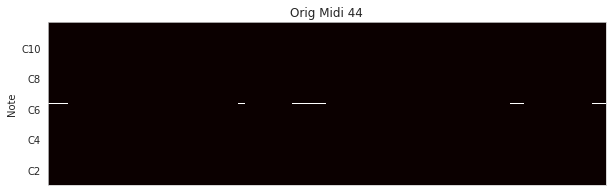

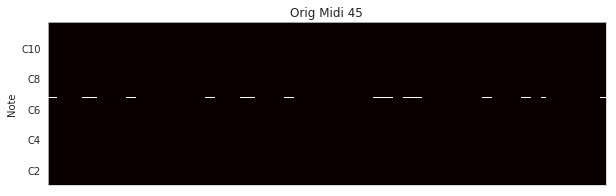

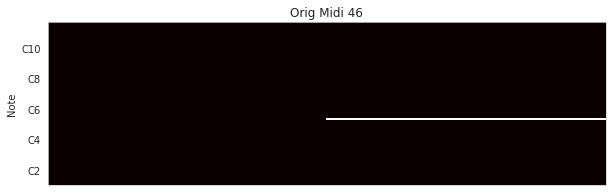

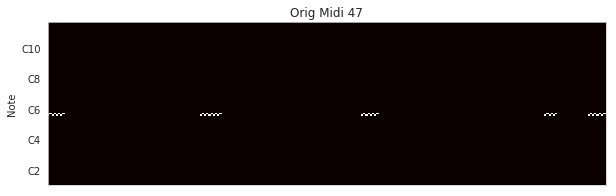

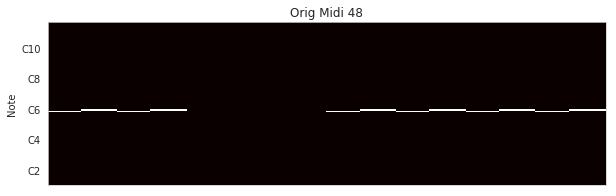

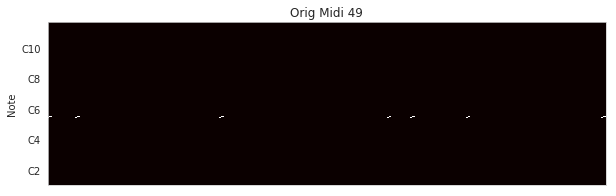

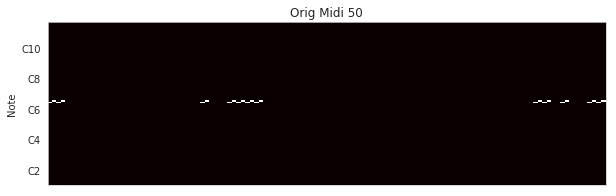

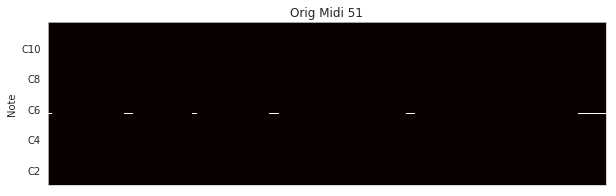

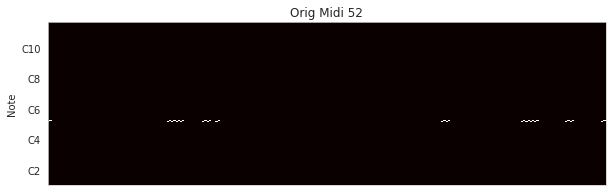

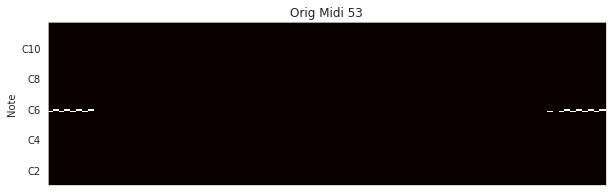

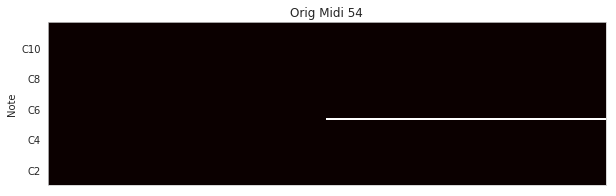

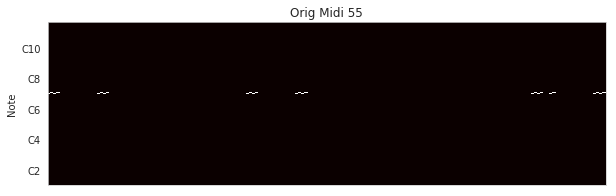

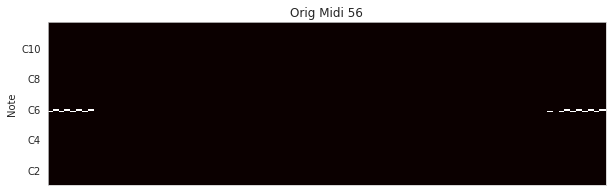

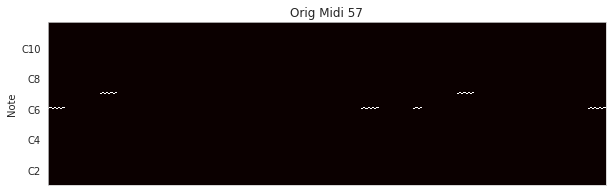

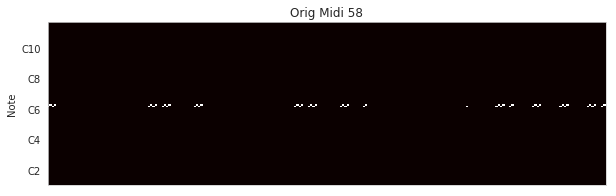

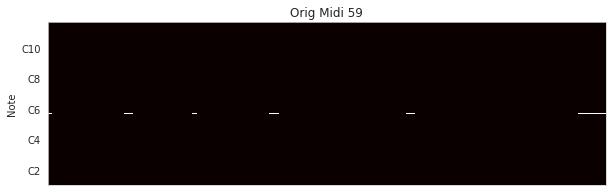

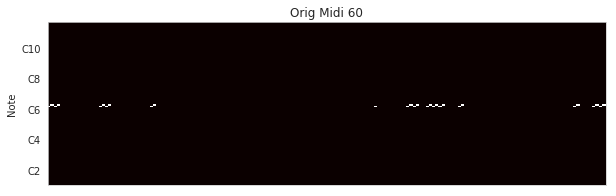

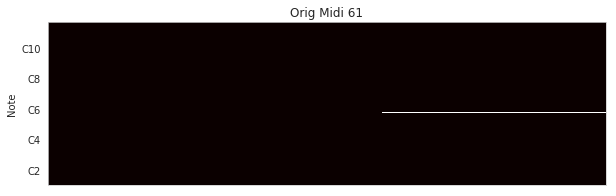

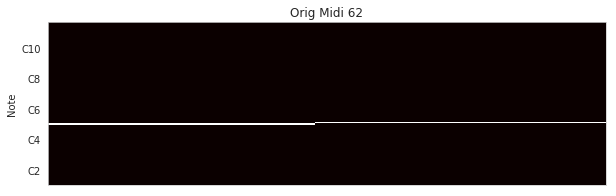

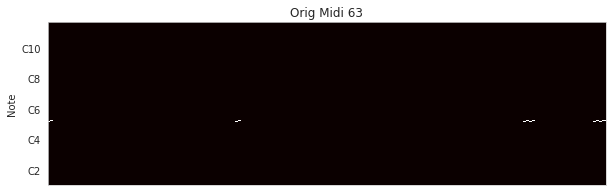

In [12]:
x_np = x.detach().numpy()
x_np.shape
for i, seq in enumerate(x_np):
    midi_out = seq

    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue
    
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Orig Midi {}".format(i))
    
    builder.plot_midi(midi)
    plt.savefig("midi/img_midi_{}_orig.png".format(i))

    midi.write('midi/{}_orig.mid'.format(i))

    #synth, rate = builder.play_midi(midi)
    #Audio(synth, rate=rate)

# Generate from the latent space

In [20]:
gen_batch = 10
z_gen = torch.randn(gen_batch, 256, 32).cuda()

# Sample from latent space
h_gen,c_gen,hconductor_gen,cconductor_gen = net.init_hidden(gen_batch)
conductor_hidden_gen = (hconductor_gen,cconductor_gen)


notes_gen = torch.zeros(gen_batch,TOTAL_NOTES,NUM_PITCHES,device=device)

# For the first timestep the note is the embedding
note_gen = torch.zeros(gen_batch, 1 , NUM_PITCHES,device=device)


decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))

counter=0

print(sequence_length)
print(notes_gen.shape)
for i in range(totalbars):
    decoder_hidden_gen = (torch.randn(1,gen_batch, decoders_initial_size,device=device), torch.randn(1,gen_batch, decoders_initial_size,device=device))
    embedding_gen, conductor_hidden_gen = net.conductor(z_gen[:,i,:].view(gen_batch,1, -1), conductor_hidden_gen)
    
    for _ in range(sequence_length):
        # Concat embedding with previous note

        e_gen = torch.cat([embedding_gen, note_gen], dim=-1)
        e_gen = e_gen.view(gen_batch, 1, -1)

        # Generate a single note (for each batch)
        note_gen, decoder_hidden_gen = net.decoder(e_gen, decoder_hidden_gen)

        aux_gen = net.linear(note_gen)

        aux_gen=torch.softmax(aux_gen, dim=2);
        #notes_gen[:,range(i*16,i*16+16),:]=aux_gen;
        notes_gen[:,counter,:]=aux_gen.squeeze();

        note_gen=aux_gen
        counter = counter+1

notes_gen

16
torch.Size([10, 256, 61])


tensor([[[2.1950e-03, 4.8683e-03, 7.1762e-03,  ..., 5.5493e-04,
          4.7984e-04, 1.2280e-01],
         [1.9702e-05, 7.3981e-04, 1.0766e-04,  ..., 4.8150e-06,
          1.0621e-05, 1.8472e-01],
         [1.5137e-05, 8.6905e-05, 7.2135e-06,  ..., 3.7091e-07,
          1.6108e-06, 2.7152e-01],
         ...,
         [5.4211e-05, 1.8490e-05, 2.3919e-04,  ..., 1.2148e-10,
          4.6622e-07, 4.3652e-01],
         [6.4464e-05, 1.8817e-05, 2.5551e-04,  ..., 1.1130e-10,
          3.7533e-07, 4.3906e-01],
         [7.4499e-05, 1.8836e-05, 2.6680e-04,  ..., 1.0212e-10,
          3.1187e-07, 4.3942e-01]],

        [[2.1021e-02, 7.7076e-05, 2.1228e-03,  ..., 2.1344e-05,
          8.4191e-06, 9.4550e-02],
         [1.2314e-02, 1.2791e-04, 4.0858e-03,  ..., 2.6053e-09,
          9.2868e-09, 9.1320e-02],
         [3.8820e-03, 1.3712e-04, 1.2803e-03,  ..., 1.3739e-09,
          6.0626e-10, 2.7542e-01],
         ...,
         [5.3761e-04, 5.6987e-05, 1.6161e-03,  ..., 3.6879e-10,
          1.960

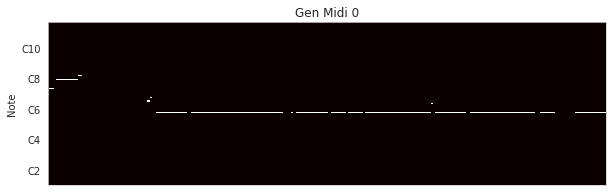

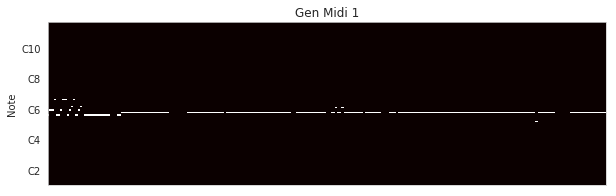

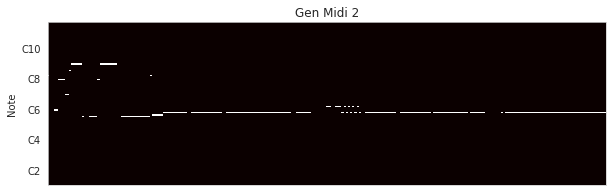

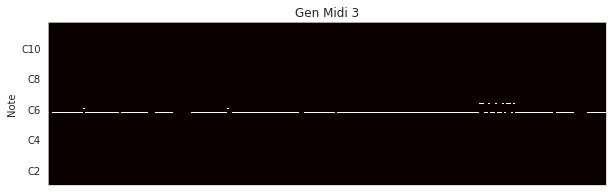

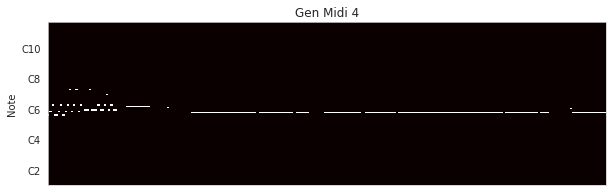

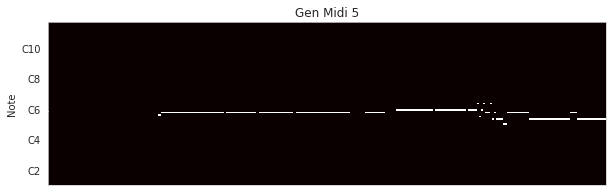

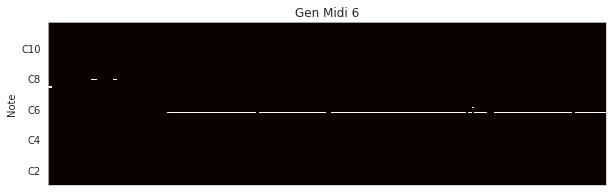

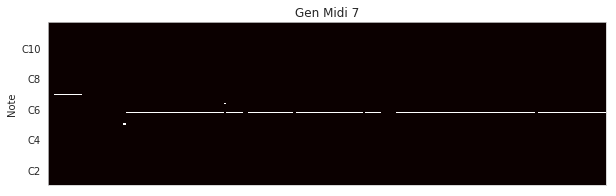

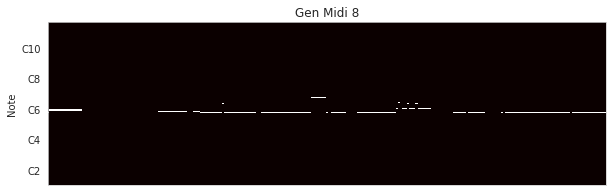

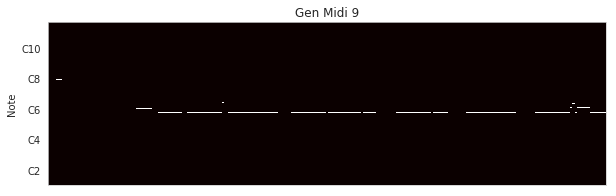

In [21]:
notes_np = notes_gen.cpu().detach().numpy()
notes_np.shape
for i, seq in enumerate(notes_np):
    row_maxes = seq.max(axis=1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:,-1]):
        print("Midi: {} is all silent".format(i))
        continue

    np.savetxt("midi/gen_csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))
    
    builder.plot_midi(midi)
    plt.savefig("midi/gen_img_midi_{}.png".format(i))

    midi.write('midi/gen_{}.mid'.format(i))